In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6


from IPython.core.pylabtools import figsize
import pymc as pm

import datetime

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import pprint

In [2]:
pd.options.display.max_rows = 1999
pd.options.display.max_columns = 1999

In [3]:
df=pd.read_csv('series.csv')
pprint.pprint(df.info())
df['Date']=df['Date'].apply(lambda x: pd.to_datetime(str(x)))
df.index=df['Date']
pprint.pprint(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 417 entries, 0 to 416
Data columns (total 2 columns):
Date    417 non-null object
ts      417 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 417 entries, 2016-10-26 to 2017-12-16
Data columns (total 2 columns):
Date    417 non-null datetime64[ns]
ts      417 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 9.8 KB
None


,Date,ts
Date,,
2016-10-26,2016-10-26,98
2016-10-27,2016-10-27,110
2016-10-28,2016-10-28,130
2016-10-29,2016-10-29,252
2016-10-30,2016-10-30,238


In [4]:
data = np.array(df['ts'])
data_len = len(data)

alpha = 1.0 / ((data.mean())**.25) #higher the alpha, more sensitive to large peaks
alpha

0.28143784353730655

In [5]:
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)
lambda_4 = pm.Exponential("lambda_4", alpha)

tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=data_len)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=data_len)
tau_3 = pm.DiscreteUniform("tau_3", lower=tau_2, upper=data_len)

@pm.deterministic
def lambda_(tau_1=tau_1,
            tau_2=tau_2,
            tau_3=tau_3,
            lambda_1=lambda_1,
            lambda_2=lambda_2,
            lambda_3=lambda_3,
            lambda_4=lambda_4,):
    out = np.zeros(data_len) # number of data points
    out[:tau_1]      = lambda_1 # lambda before tau is lambda_1
    out[tau_1:tau_2] = lambda_2 #lambda before tau is lambda_2
    out[tau_2:tau_3] = lambda_3 #lambda before tau is lambda_3
    out[tau_3:]      = lambda_4 #
    
    return out

observation = pm.Poisson("obs", lambda_, value=data, observed=True)

model = pm.Model([observation,lambda_1,lambda_2,lambda_3,lambda_4,tau_1,tau_2,tau_3])
mcmc = pm.MCMC(model)
mcmc.sample(1111111,11111)

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
lambda_3_samples = mcmc.trace('lambda_3')[:]
lambda_4_samples = mcmc.trace('lambda_4')[:]

tau_1_samples = mcmc.trace('tau_1')[:]
tau_2_samples = mcmc.trace('tau_2')[:]
tau_3_samples = mcmc.trace('tau_3')[:]

N = tau_1_samples.shape[0]
expected_1 = np.zeros(data_len)
expected_2 = np.zeros(data_len)
expected_3 = np.zeros(data_len)

for d in range(0, data_len):
    ix = d < tau_1_samples
    expected_1[d] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

    ix2 = np.logical_and(d > tau_1_samples, d < tau_2_samples)
    expected_2[d] = (lambda_2_samples[ix2].sum() + lambda_3_samples[~ix2].sum()) / N
    
    ix3 = np.logical_and(d > tau_2_samples,d < tau_3_samples)
    expected_3[d] = (lambda_3_samples[ix3].sum() + lambda_4_samples[~ix3].sum()) / N
    
df['expected_1']=expected_1
df['expected_2']=expected_2
df['expected_3']=expected_3

df['expected']=list(df['expected_1'])[:tau_1.value]+list(df['expected_2'])[tau_1.value:tau_2.value+2]+\
list(df['expected_3'])[tau_2.value+2:]

 [-----------------100%-----------------] 1111111 of 1111111 complete in 462.4 sec

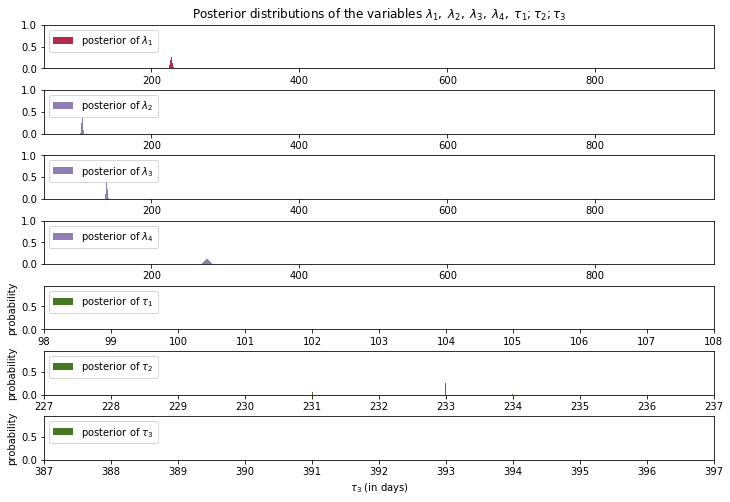

In [6]:
figsize(12, 8)

ax = plt.subplot(711)
ax.set_autoscaley_on(False)
plt.subplots_adjust(hspace=.5)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables $\lambda_1,\;\lambda_2,\;\lambda_3,\;\lambda_4,\;\tau_1;\tau_2;\tau_3$""")
plt.xlim([df['ts'].min(), df['ts'].max()])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(712)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([df['ts'].min(), df['ts'].max()])
plt.xlabel("$\lambda_2$ value")

ax = plt.subplot(713)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label="posterior of $\lambda_3$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([df['ts'].min(), df['ts'].max()])
plt.xlabel("$\lambda_3$ value")

ax = plt.subplot(714)
ax.set_autoscaley_on(False)
plt.hist(lambda_4_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label="posterior of $\lambda_4$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([df['ts'].min(), df['ts'].max()])
plt.xlabel("$\lambda_4$ value")

plt.subplot(715)
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_1_samples)
plt.hist(tau_1_samples, bins=data_len, alpha=1,label=r"posterior of $\tau_1$",color="#467821", weights=w, rwidth=4.)
plt.xticks(np.arange(data_len))
plt.legend(loc="upper left")
plt.ylim([0,0.95])
plt.xlim([np.argmax(np.bincount(tau_1_samples))-5,np.argmax(np.bincount(tau_1_samples))+5 ])
plt.xlabel(r"$\tau_1$ (in days)")
plt.ylabel("probability");

plt.subplot(716)
w = 1.0 / tau_2_samples.shape[0] * np.ones_like(tau_2_samples)
plt.hist(tau_2_samples, bins=data_len, alpha=1,label=r"posterior of $\tau_2$",color="#467821", weights=w, rwidth=4.)
plt.xticks(np.arange(data_len))
plt.legend(loc="upper left")
plt.ylim([0,0.95])
plt.xlim([np.argmax(np.bincount(tau_2_samples))-5,np.argmax(np.bincount(tau_2_samples))+5 ])
plt.xlabel(r"$\tau_2$ (in days)")
plt.ylabel("probability");

plt.subplot(717)
w = 1.0 / tau_3_samples.shape[0] * np.ones_like(tau_3_samples)
plt.hist(tau_3_samples, bins=data_len, alpha=1,label=r"posterior of $\tau_3$",color="#467821", weights=w, rwidth=4.)
plt.xticks(np.arange(data_len))
plt.legend(loc="upper left")
plt.ylim([0,0.95])
plt.xlim([np.argmax(np.bincount(tau_3_samples))-5,np.argmax(np.bincount(tau_3_samples))+5 ])
plt.xlabel(r"$\tau_3$ (in days)")
plt.ylabel("probability");

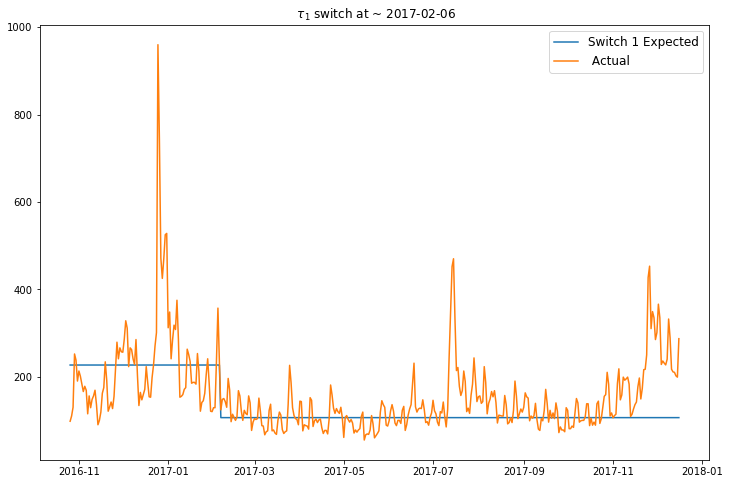

In [7]:
plt.plot(df['expected_1'],label="Switch 1 Expected")
plt.plot(df['ts'], label=" Actual ")
plt.title(r" $\tau_1$"+' switch at ~ '+str(df.index[int(tau_1.value):tau_1.value+1][0].date().strftime("%Y-%m-%d")) )
plt.legend(loc='best',prop={'size': 12})

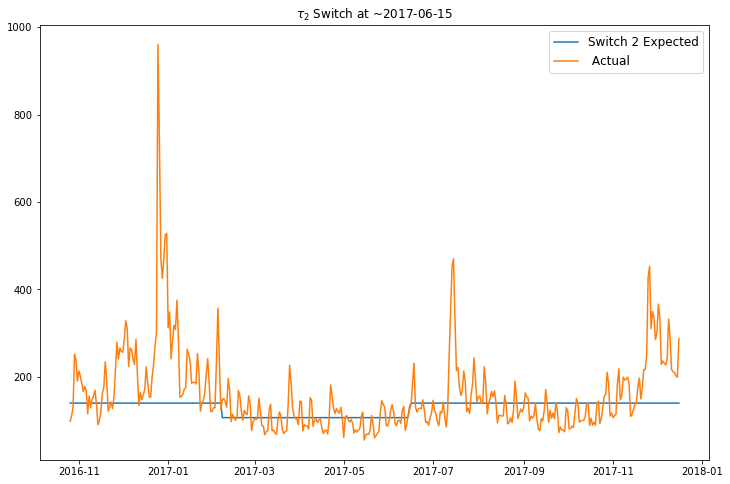

In [8]:
plt.plot(df['expected_2'],label="Switch 2 Expected")
plt.plot(df['ts'],label=" Actual ")
plt.title(r'$\tau_2$'+' Switch at ~'+str(df.index[int(tau_2.value):tau_2.value+1][0].date().strftime("%Y-%m-%d")) )
plt.legend(loc='best',prop={'size': 12})

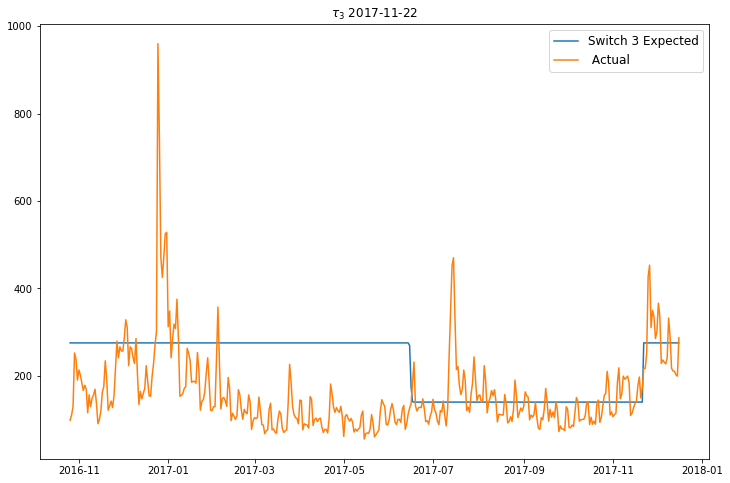

In [9]:
plt.plot(df['expected_3'],label="Switch 3 Expected")
plt.plot(df['ts'],label=" Actual ")
plt.title(r'$\tau_3$'+' '+str(df.index[int(tau_3.value):tau_3.value+1][0].date().strftime("%Y-%m-%d")) )
plt.legend(loc='best',prop={'size': 12})

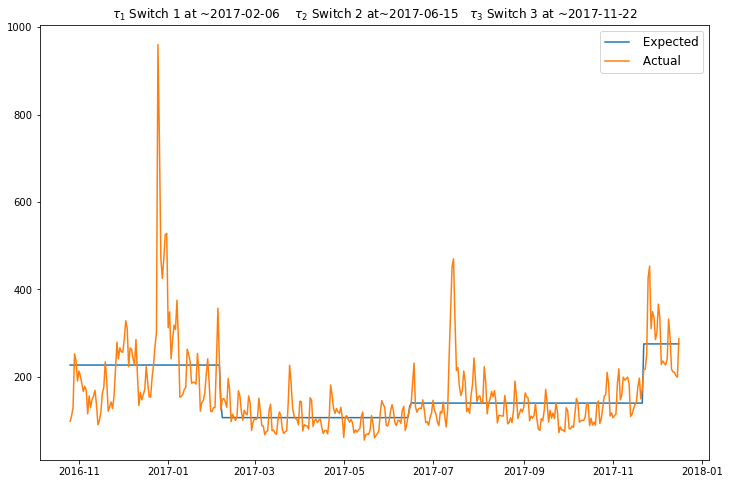

In [10]:
plt.plot(df['expected'],label=" Expected")
plt.plot(df['ts'],label=" Actual ")
plt.title(r'$\tau_1$'+' Switch 1 at ~'+str(df.index[int(tau_1.value):tau_1.value+1][0].date().strftime("%Y-%m-%d"))+ "    "+r'$\tau_2$'+' Switch 2 at~'+str(df.index[int(tau_2.value):tau_2.value+1][0].date().strftime("%Y-%m-%d"))+ "   "+r'$\tau_3$'+' Switch 3 at ~'+str(df.index[int(tau_3.value):tau_3.value+1][0].date().strftime("%Y-%m-%d")))
plt.legend(loc='best',prop={'size': 12})